# Lab 10: Dialogue Act Tagging

Dialogue act (DA) tagging is an important step in the process of developing dialog systems. DA tagging is a problem usually solved by supervised machine learning approaches that all require large amounts of hand labeled data. A wide range of techniques have been investigated for DA tagging. In this lab, we explore two models for DA classification. We are using the Switchboard Dialog Act Corpus for training.
Corpus can be downloaded from http://compprag.christopherpotts.net/swda.html.


The downloaded dataset should be kept in a data folder in the same directory as this file. 

In [0]:
import pandas as pd
import glob

import zipfile
import os
import tarfile

In [7]:
# For use with Colab - Check on GPU
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 11.4 GB  | Proc size: 144.7 MB
GPU RAM Free: 10139MB | Used: 1302MB | Util  11% | Total 11441MB


In [9]:
!wget http://compprag.christopherpotts.net/code-data/swda.zip
  

--2019-03-28 01:19:48--  http://compprag.christopherpotts.net/code-data/swda.zip
Resolving compprag.christopherpotts.net (compprag.christopherpotts.net)... 64.90.36.20
Connecting to compprag.christopherpotts.net (compprag.christopherpotts.net)|64.90.36.20|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14040987 (13M) [application/zip]
Saving to: ‘swda.zip’

swda.zip            100%[===================>]  13.39M  9.04MB/s    in 1.5s    

2019-03-28 01:19:50 (9.04 MB/s) - ‘swda.zip’ saved [14040987/14040987]



In [0]:
path_to_zip_file = 'swda.zip'
directory_to_extract_to = os.getcwd()  

zip_ref = zipfile.ZipFile(path_to_zip_file, 'r')
zip_ref.extractall(directory_to_extract_to)
zip_ref.close()
  

In [11]:
os.listdir()  # Check files are all there


['.config',
 '__MACOSX',
 'swda',
 'data.30.en',
 'swda.zip',
 'data.30.vi',
 'sample_data']

In [0]:
f = glob.glob("swda/sw*/sw*.csv") #csv??

#f = glob.glob("sw*/sw*.utt")
frames = []
for i in range(0, len(f)):
    frames.append(pd.read_csv(f[i]))  
    #frames.append(pd.read_csv(f[i], error_bad_lines=False))
result = pd.concat(frames, ignore_index=True)


In [13]:
print("Number of converations in the dataset:",len(result))

Number of converations in the dataset: 223606


The dataset has many different features, we are only using act_tag and text for this training.


In [0]:
reduced_df = result[['act_tag','text']]


In [15]:
reduced_df.head()


,act_tag,text
0,o,"Okay, {F uh. } /"
1,qy,Do you have annual family reunions /
2,%,"{C or, } -/"
3,ny,"{F Uh, } yeah, /"
4,%,"{F uh, } our, - /"


Theere are 43 tags in this dataset. Some of the tags are Yes-No-Question('qy'), Statement-non-opinion('sd') and Statement-opinion('sv'). Tags information can be found here http://compprag.christopherpotts.net/swda.html#tags. 


You can check the frequency of tags.

In [16]:
reduced_df['act_tag'].value_counts()


sd            70464
b             36180
sv            25696
+             17813
%             15547
aa            10136
ba             4523
qy             3785
x              3628
ny             2826
fc             2404
b^r            2102
sd^e           1939
qw             1890
sd(^q)         1341
bk             1254
nn             1230
h              1218
qy^d           1217
bh             1044
^q              972
bf              934
sd^t            929
aa^r            916
+@              867
o               801
na              764
^2              714
b^m             688
ad              666
              ...  
b^2               1
sd^r@             1
sd^m@             1
aap^r             1
qo^d^c            1
qw^d@             1
t1^t              1
^2^t              1
h,sd              1
fw*               1
^2^r              1
bh,sd,o@          1
b^m,sd,o@         1
no@               1
sv^e^r            1
qo^r              1
sd;sv             1
bd@               1
qh*               1


## Baseline BiLSTM Model

To get unique tags. 

In [0]:
unique_tags = set()
for tag in reduced_df['act_tag']:
    unique_tags.add(tag)

In [0]:
one_hot_encoding_dic = pd.get_dummies(list(unique_tags))


In [0]:
tags_encoding = []
for i in range(0, len(reduced_df)):
    tags_encoding.append(one_hot_encoding_dic[reduced_df['act_tag'].iloc[i]])

The tags are one hot encoded.

To create sentence embeddings:

In [0]:
sentences = []
for i in range(0, len(reduced_df)):
    sentences.append(reduced_df['text'].iloc[i].split(" "))


In [0]:
wordvectors = {}
index = 1
for s in sentences:
    for w in s:
        if w not in wordvectors:
            wordvectors[w] = index
            index += 1

In [0]:
MAX_LENGTH = len(max(sentences, key=len))


In [0]:
sentence_embeddings = []
for s in sentences:
    sentence_emb = []
    for w in s:
        sentence_emb.append(wordvectors[w])
    sentence_embeddings.append(sentence_emb)


Then we split the dataset into test and train.

In [0]:
from sklearn.model_selection import train_test_split
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(sentence_embeddings, np.array(tags_encoding))


In [25]:
tot = len(X_train) + len(X_test)
print(len(X_train)/tot)
print(len(X_test))



0.7499977639240449
55902


And pad the sentences with zero to make all sentences of equal length.


In [26]:
y_train.shape

(167704, 303)

In [27]:
from keras.preprocessing.sequence import pad_sequences
 
train_sentences_X = pad_sequences(X_train, maxlen=MAX_LENGTH, padding='post')
test_sentences_X = pad_sequences(X_test, maxlen=MAX_LENGTH, padding='post')

# train_sentences_y = pad_sequences(y_train, maxlen=MAX_LENGTH, padding='post')
# test_sentences_y = pad_sequences(y_test, maxlen=MAX_LENGTH, padding='post')


Using TensorFlow backend.


 The model architecture is as follows: Embedding Layer (to generate word embeddings) Next layer Bidirectional LSTM. Feed forward layer with number of neurons = number of tags. Softmax activation to get probabilities.

In [28]:
train_sentences_X.shape

(167704, 137)

In [29]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout, InputLayer, Bidirectional, TimeDistributed, Activation, Embedding
from keras.optimizers import Adam
#Building the network
vocab_size = len(wordvectors)
num_tags = len(unique_tags)

model = Sequential()

# Embedding Layer
# Set the input dimension to the vocabulary size as counted in the word vectors
# Set Output dimension to the maximum sequence length
model.add(Embedding(vocab_size,MAX_LENGTH)) 

# Bidirectional LSTM
# Output dimension of the embedding layer is passed to this layer
model.add(Bidirectional(LSTM(MAX_LENGTH)))

# Feed forward layer with number of neurons = number of tags. 
# Softmax activation to get multiple probabilities.
model.add(Dense(num_tags))
model.add(Activation('softmax'))          
          
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 137)         5991147   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 274)               301400    
_________________________________________________________________
dense_1 (Dense)              (None, 303)               83325     
_________________________________________________________________
activation_1 (Activation)    (None, 303)               0         
Total params: 6,375,872
Trainable params: 6,375,872
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Set loss (categorical cross entropy for multiple outputs)
# Select optimiser - the adaptive momentum optimiser, Adam 
f_optimizer = 'adam'
f_loss='categorical_crossentropy'

#model.compile(optimizer = f_optimizer, loss=f_loss, accuracy = ['metrics'])
model.compile(optimizer = f_optimizer, loss=f_loss, metrics = ['accuracy'])

'''
history = model.fit(train_sentences_X,
                    #train_sentences_y,
                    epochs = 1,
                    batch_size=512,
                    #validation_data=(test_sentences_X, test_sentences_y),
                    verbose = 1)
'''

history = model.fit(train_sentences_X,
                    y_train,
                    epochs = 5,
                    batch_size=512,
                    verbose=1)


Instructions for updating:
Use tf.cast instead.
Epoch 1/5
167704/167704 [==============================] - 176s 1ms/step - loss: 2.0253 - acc: 0.5031
Epoch 2/5
167704/167704 [==============================] - 174s 1ms/step - loss: 1.3590 - acc: 0.6389
Epoch 3/5
167704/167704 [==============================] - 170s 1ms/step - loss: 1.1428 - acc: 0.6898
Epoch 4/5
167704/167704 [==============================] - 170s 1ms/step - loss: 1.0191 - acc: 0.7175
Epoch 5/5
167704/167704 [==============================] - 170s 1ms/step - loss: 0.9370 - acc: 0.7372


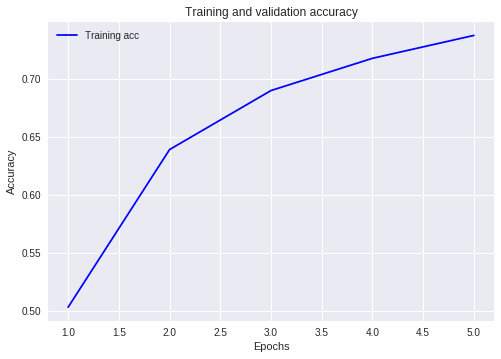

In [31]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['acc']
#val_acc = history_dict['val_acc']
loss = history_dict['loss']
#val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
#plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [32]:
X_train[0]

[13, 250, 4, 94, 35, 72, 21, 2555, 12, 5]

In [33]:
score = model.evaluate(test_sentences_X, y_test, batch_size=100)

55902/55902 [==============================] - 57s 1ms/step


In [34]:
print(score)
print("Accuracy:", score[1]*100)


[1.1247087091539103, 0.6836785816821312]
Accuracy: 68.36785816821312


In addition to overall accuracy, you need to look at the accuracy of some minority classes. Signal-non-understanding ('br') is a good indicator of "other-repair" or cases in which the other conversational participant attempts to repair the speaker's error. Summarize/reformulate ('bf') has been used in dialogue summarization. Report the accuracy for these classes and some frequent errors you notice the system makes in predicting them. What do you think the reasons are？


As the dataset is highly imbalanced, we can simply weight up the minority classes proportionally to their underrepresentation while training. 

In [0]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

y_integers = np.argmax(tags_encoding, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

In [0]:
#f_optimizer = 'adam'
#f_loss='categorical_crossentropy'

#model.compile(optimizer = f_optimizer, loss=f_loss, metrics = ['accuracy'])

In [37]:
model.fit(train_sentences_X, y_train, batch_size=100, epochs=5, class_weight = d_class_weights)

Epoch 1/5
167704/167704 [==============================] - 699s 4ms/step - loss: 5.2486 - acc: 0.3708
Epoch 2/5
167704/167704 [==============================] - 697s 4ms/step - loss: 4.1394 - acc: 0.3598
Epoch 3/5
167704/167704 [==============================] - 696s 4ms/step - loss: 3.0942 - acc: 0.3095
Epoch 4/5
167704/167704 [==============================] - 695s 4ms/step - loss: 2.1793 - acc: 0.3320
Epoch 5/5
167704/167704 [==============================] - 698s 4ms/step - loss: 1.4634 - acc: 0.3068


In [38]:
#from sklearn.metrics import confusion_matrix

len(sentences)

223606

In [39]:
#print(class_names)
reduced_df

,act_tag,text
0,o,"Okay, {F uh. } /"
1,qy,Do you have annual family reunions /
2,%,"{C or, } -/"
3,ny,"{F Uh, } yeah, /"
4,%,"{F uh, } our, - /"
5,%,the - /
6,sd^e,my mother's side of the family [ is quite lar...
7,sd,"{C and, } {F uh, } <throat_clearing> they, {F..."
8,sd,"back, {F uh, } early on they used [ to, + to..."
9,b,Uh-huh. /


Report the overall accuracy and the accuracy of  'br' and 'bf'  classes. Suggest other ways to handle imbalanced classes.

Can we improve things by using context information?  Next we try to build a model which predicts DA tag from the sequence of 
previous DA tags, plus the utterance representation. 

##Using Context for Dialog Act Classification
We expect there is valuable sequential information among the DA tags. So in this section we apply a BiLSTM on top of the sentence CNN representation. The CNN model learns textual information in each sentence for DA classification. Here, we use bidirectional-LSTM (BLSTM) to learn the context before and after the current sentence. The left-to-right LSTM output and the one from the reverse direction are concatenated and input to a hidden layer for classification.

Functions for creating weights and biases.

In [0]:
import tensorflow as tf

def weights_init(shape):
    return tf.Variable(tf.truncated_normal(shape=shape, stddev=0.05))

In [0]:
def bias_init(shape):
    return tf.Variable(tf.zeros(shape=shape))


 This is classical CNN layer used to convolve over embedings tensor and gether useful information from it. The data is represented by hierarchy of features, which can be modelled using a CNN.
    
      Input(s): 
              input - word_embedings
              filter_size - size of width and height of the Conv kernel
              number_of_channels - in this case it is always 1
              number_of_filters - how many representation of the input utterance are we going to output from this layer 
              strides - how many does kernel move to the side and up/down
              activation - a activation function
              max_pool - boolean value which will trigger a max_pool operation on the output tensor
      Output(s): 
               text_conv layer
    

In [0]:
def text_conv(input, filter_size, number_of_channels, number_of_filters, strides=(1, 1), activation=tf.nn.relu, max_pool=True):
    
    weights = weights_init([filter_size, filter_size, number_of_channels, number_of_filters])
    bias = bias_init([number_of_filters])
    
    layer = tf.nn.conv2d(input, filter=weights, strides=[1, strides[0], strides[1], 1], padding='SAME')
    
    if activation != None:
        layer = activation(layer)
    
    if max_pool:
        layer = tf.nn.max_pool(layer, ksize=[1, 2, 2 ,1], strides=[1, 2, 2, 1], padding='SAME')
    
    return layer

    This method is used to create LSTM layer. And the data we’re working with has temporal properties which we want to model as well — hence the use of a LSTM. You can create a BiLSTM by modifying this.
    
    Input(s): lstm_cell_unitis - used to define the number of units in a LSTM layer
              number_of_layers - used to define how many of LSTM layers do we want in the network
              batch_size - in this method this information is used to build starting state for the network
              dropout_rate - used to define how many cells in a layer do we want to 'turn off'
              
    Output(s): cell - lstm layer
               init_state - zero vectors used as a starting state for the network

In [0]:
def lstm_layer(lstm_size, number_of_layers, batch_size, dropout_rate):

    def cell(size, dropout_rate=None):
        layer = tf.contrib.rnn.BasicLSTMCell(lstm_size)
        
        return tf.contrib.rnn.DropoutWrapper(layer, output_keep_prob=dropout_rate)
            
    cell = tf.contrib.rnn.MultiRNNCell([cell(lstm_size, dropout_rate) for _ in range(number_of_layers)])
    
    init_state = cell.zero_state(batch_size, tf.float32)
    return cell, init_state

    Use to transform/reshape conv output to 2d matrix, if it's necessary
    
    Input(s): Layer - text_cnn layer
              batch_size - how many samples do we feed at once
              seq_len - number of time steps
              
    Output(s): reshaped_layer - the layer with new shape
               number_of_elements - this param is used as a in_size for next layer

In [0]:
def flatten(layer, batch_size, seq_len):

    dims = layer.get_shape()
    number_of_elements = dims[2:].num_elements()
    
    reshaped_layer = tf.reshape(layer, [batch_size, int(seq_len/2), number_of_elements])
    return reshaped_layer, number_of_elements

    Output layer for the lstm netowrk
    
    Input(s): lstm_outputs - outputs from the RNN part of the network
              input_size - in this case it is RNN size (number of neuros in RNN layer)
              output_size - number of neuros for the output layer == number of classes
              
    Output(s) - logits, 

In [0]:
def dense_layer(input, in_size, out_size, dropout=False, activation=tf.nn.relu):
  
    weights = weights_init([in_size, out_size])
    bias = bias_init([out_size])
    
    layer = tf.matmul(input, weights) + bias
    
    if activation != None:
        layer = activation(layer)
    
    if dropout:
        layer = tf.nn.dropout(layer, 0.5)
        
    return layer

    Function used to calculate loss and minimize it
    
    Input(s): rnn_out - logits from the fully_connected layer
              targets - targets used to train network
              learning_rate/step_size
    
    
    Output(s): optimizer - optimizer of choice
               loss - calculated loss function

In [0]:
def loss_optimizer(logits, targets, learning_rate, ):

    #loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=targets))
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=targets))
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    return loss, optimizer

To create the model you can use these inputs:     
       
       Input(s): learning_rate/step_size - how fast are we going to find global minima
                  batch_size -  the nuber of samples to feed at once
                  seq_len - the number of timesteps in unrolled RNN
                  vocab_size - the number of nunique words in the vocab
                  embed_size - length of word embed vectors
                  conv_filters - number of filters in output tensor from CNN layer
                  conv_filter_size - height and width of conv kernel
                  number_of_lstm_layers - the number of layers used in the LSTM part of the network
                  lstm_units - the number of neurons/cells in a LSTM layer

In [0]:

class DATagging(object):
    
    def __init__(self, learning_rate=0.001, batch_size=256, seq_len=250, vocab_size=10000, embed_size=300,
                conv_filters=32, conv_filter_size=5, number_of_lstm_layers=1, lstm_units=128):
      
        #Clear graph
        tf.reset_default_graph()
        
        # Set up inputs - placeholders for values to be filled later
        # Note: Shape of targets and logits needs to be the same
        self.inputs = tf.placeholder(tf.int32, [batch_size, seq_len], name='inputs')
#        self.targets = tf.placeholder(tf.float32, [batch_size, 1], name='targets')
        self.targets = tf.placeholder(tf.float32, [batch_size, 303], name='targets')
        self.keep_probs = tf.placeholder(tf.float32, name='keep_probs')
        
        
        
        #self.inputs, self.targets, self.keep_probs = define_inputs(batch_size, seq_len)
        
        # Embedding layer
        # Start with vocab size as input shape
        # Note the need to reshape by adding a dimension of 1 at the end before
        # passing the output to the convolutional layer which is conv2d 
        # c.f. adding a channel in image processing with conv2d
        sentence_embeddings = tf.Variable(tf.random_uniform([vocab_size,embed_size]))
        embedding_layer = tf.nn.embedding_lookup(sentence_embeddings, self.inputs)
        embedding_layer=tf.expand_dims(embedding_layer, -1)

        
        # Building the network
        # Convolutional layers are good at picking up context (because of their
        # use of a kernel / 'filter')
        conv_layer = text_conv(embedding_layer, conv_filter_size, 1, conv_filters)
        
        # Flatten the conv2d output before passing to the lstm (i.e. an rnn) layer
        conv_flatten, num_elements = flatten(conv_layer, batch_size, seq_len)
        
        # LSTM layer to process the output from the convolutional layer 'as normal'
        cell, init_state = lstm_layer(lstm_units, number_of_lstm_layers, batch_size, self.keep_probs)
        
        outputs, states = tf.nn.dynamic_rnn(cell, conv_flatten, initial_state=init_state)
        
        review_outputs = outputs[:, -1, :]   #slicing - need to use tf
        #review_outputs = tf.slice(outputs,[:, -1, :])
        #review_outputs =tf.expand_dims(outputs,-1)
        #new_outputs=tf.reshape(outputs,[-2])
        #print('got up to here')
        #print(outputs.shape)
        #print(review_outputs.shape)
        #print(new_outputs.shape)
        #logits = dense_layer(review_outputs, lstm_units, 1, activation=None)
        
        # Fully connected dense layer to produce the logits (hence no activation)
        #  - again relatively 'standard'
        logits = dense_layer(review_outputs, lstm_units, 303, activation=None)
        
        self.loss, self.opt = loss_optimizer(logits, self.targets, learning_rate)
        
        preds = tf.nn.sigmoid(logits)
        currect_pred = tf.equal(tf.cast(tf.round(preds), tf.int32), tf.cast(self.targets, tf.int32))
        self.accuracy = tf.reduce_mean(tf.cast(currect_pred, tf.float32))

In [48]:
model = DATagging(learning_rate=0.001, 
                     batch_size=256, 
                     seq_len=250,
                     vocab_size=len(wordvectors) + 1, 
                     embed_size=300,
                     conv_filters=32, 
                     conv_filter_size=5, 
                     number_of_lstm_layers=1, 
                     lstm_units=128
                 )




For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [0]:
session = tf.Session()

In [0]:
session.run(tf.global_variables_initializer())

In [0]:
epochs = 5
batch_size = 256
drop_rate = 0.5

In [0]:
'''
X_train= pad_sequences(X_train, maxlen=250, padding='post')
#X_test = pad_sequences(X_test, maxlen=seq_len padding='post')

y_train = pad_sequences(y_train, maxlen=250, padding='post')
#y_test = pad_sequences(y_test, maxlen=MAX_LENGTH, padding='post')
'''
train_sentences_X = pad_sequences(X_train, maxlen=250, padding='post')
test_sentences_X = pad_sequences(X_test, maxlen=250, padding='post')

# train_sentences_y = pad_sequences(y_train, maxlen=250, padding='post')
# test_sentences_y = pad_sequences(y_test, maxlen=250, padding='post')
#X_train = features[:6400]
#y_train = labels[:6400]

#X_test = features[6400:]
#y_test = labels[6400:]

In [53]:
#Training
from tqdm import tqdm_notebook as tqdm #Shows output in notebook while running

for i in range(epochs):
    epoch_loss = []
    train_accuracy = []
    for ii in tqdm(range(0, len(X_train) - len(X_train) % batch_size, batch_size)):
        #X_batch = X_train[ii:ii+batch_size]
        X_batch = train_sentences_X[ii:ii+batch_size] 
        y_batch = y_train[ii:ii+batch_size] 

        c, _, a = session.run([model.loss, model.opt, model.accuracy], feed_dict={model.inputs:X_batch,         # or train_sentences_X, 
                                                                                  model.targets:y_batch,       #or y_train?
                                                                                  model.keep_probs:drop_rate}) 
        epoch_loss.append(c)
        train_accuracy.append(a)
    
        
        print("Epoch: {}/{}".format(i+1, epochs), " | Epoch loss: {}".format(np.mean(epoch_loss)),
            " | Mean train accuracy: {}".format(np.mean(train_accuracy)))
        
print("Training finished")  
#session.close()

Epoch: 1/5  | Epoch loss: 5.6850080490112305  | Mean train accuracy: 0.5035581588745117
Epoch: 1/5  | Epoch loss: 5.483322620391846  | Mean train accuracy: 0.5176296830177307
Epoch: 1/5  | Epoch loss: 5.335533142089844  | Mean train accuracy: 0.5340862274169922
Epoch: 1/5  | Epoch loss: 5.208924770355225  | Mean train accuracy: 0.5529696941375732
Epoch: 1/5  | Epoch loss: 5.093967437744141  | Mean train accuracy: 0.5734659433364868
Epoch: 1/5  | Epoch loss: 4.973893642425537  | Mean train accuracy: 0.5937178134918213
Epoch: 1/5  | Epoch loss: 4.843373775482178  | Mean train accuracy: 0.6138300895690918
Epoch: 1/5  | Epoch loss: 4.726916790008545  | Mean train accuracy: 0.633389413356781
Epoch: 1/5  | Epoch loss: 4.635969638824463  | Mean train accuracy: 0.6524526476860046
Epoch: 1/5  | Epoch loss: 4.516843318939209  | Mean train accuracy: 0.6703022122383118
Epoch: 1/5  | Epoch loss: 4.430835247039795  | Mean train accuracy: 0.6868448853492737
Epoch: 1/5  | Epoch loss: 4.348265647888184

Epoch: 2/5  | Epoch loss: 2.5534605979919434  | Mean train accuracy: 0.8891810774803162
Epoch: 2/5  | Epoch loss: 2.537715196609497  | Mean train accuracy: 0.8889168500900269
Epoch: 2/5  | Epoch loss: 2.5774247646331787  | Mean train accuracy: 0.8889705538749695
Epoch: 2/5  | Epoch loss: 2.600968599319458  | Mean train accuracy: 0.8891230821609497
Epoch: 2/5  | Epoch loss: 2.6073737144470215  | Mean train accuracy: 0.8890237808227539
Epoch: 2/5  | Epoch loss: 2.602677822113037  | Mean train accuracy: 0.8889705538749695
Epoch: 2/5  | Epoch loss: 2.6000869274139404  | Mean train accuracy: 0.8890079855918884
Epoch: 2/5  | Epoch loss: 2.6011781692504883  | Mean train accuracy: 0.888918399810791
Epoch: 2/5  | Epoch loss: 2.615891933441162  | Mean train accuracy: 0.88895183801651
Epoch: 2/5  | Epoch loss: 2.59487247467041  | Mean train accuracy: 0.8890186548233032
Epoch: 2/5  | Epoch loss: 2.6031267642974854  | Mean train accuracy: 0.8889970779418945
Epoch: 2/5  | Epoch loss: 2.6061527729034

Epoch: 3/5  | Epoch loss: 2.5725748538970947  | Mean train accuracy: 0.8904445171356201
Epoch: 3/5  | Epoch loss: 2.5344176292419434  | Mean train accuracy: 0.8903027176856995
Epoch: 3/5  | Epoch loss: 2.5723114013671875  | Mean train accuracy: 0.8900835514068604
Epoch: 3/5  | Epoch loss: 2.5912444591522217  | Mean train accuracy: 0.8901898860931396
Epoch: 3/5  | Epoch loss: 2.596583843231201  | Mean train accuracy: 0.8901815414428711
Epoch: 3/5  | Epoch loss: 2.5928404331207275  | Mean train accuracy: 0.8899653553962708
Epoch: 3/5  | Epoch loss: 2.5940988063812256  | Mean train accuracy: 0.889892041683197
Epoch: 3/5  | Epoch loss: 2.597268581390381  | Mean train accuracy: 0.8898676037788391
Epoch: 3/5  | Epoch loss: 2.6098403930664062  | Mean train accuracy: 0.8899160027503967
Epoch: 3/5  | Epoch loss: 2.587486982345581  | Mean train accuracy: 0.8898811340332031
Epoch: 3/5  | Epoch loss: 2.59639573097229  | Mean train accuracy: 0.8899160027503967
Epoch: 3/5  | Epoch loss: 2.6022927761

Epoch: 4/5  | Epoch loss: 2.5640530586242676  | Mean train accuracy: 0.8942347168922424
Epoch: 4/5  | Epoch loss: 2.5288472175598145  | Mean train accuracy: 0.8942991495132446
Epoch: 4/5  | Epoch loss: 2.569382905960083  | Mean train accuracy: 0.8944066166877747
Epoch: 4/5  | Epoch loss: 2.592202663421631  | Mean train accuracy: 0.8942508697509766
Epoch: 4/5  | Epoch loss: 2.597085475921631  | Mean train accuracy: 0.8943069577217102
Epoch: 4/5  | Epoch loss: 2.5900962352752686  | Mean train accuracy: 0.8942390084266663
Epoch: 4/5  | Epoch loss: 2.591796398162842  | Mean train accuracy: 0.8941941857337952
Epoch: 4/5  | Epoch loss: 2.592994213104248  | Mean train accuracy: 0.8940961360931396
Epoch: 4/5  | Epoch loss: 2.6062417030334473  | Mean train accuracy: 0.894124448299408
Epoch: 4/5  | Epoch loss: 2.5843050479888916  | Mean train accuracy: 0.8941109776496887
Epoch: 4/5  | Epoch loss: 2.595726490020752  | Mean train accuracy: 0.8941268920898438
Epoch: 4/5  | Epoch loss: 2.59892725944

Epoch: 5/5  | Epoch loss: 2.5593345165252686  | Mean train accuracy: 0.8976897597312927
Epoch: 5/5  | Epoch loss: 2.5350542068481445  | Mean train accuracy: 0.8977671265602112
Epoch: 5/5  | Epoch loss: 2.568711519241333  | Mean train accuracy: 0.8975479602813721
Epoch: 5/5  | Epoch loss: 2.5909786224365234  | Mean train accuracy: 0.8974931836128235
Epoch: 5/5  | Epoch loss: 2.591726779937744  | Mean train accuracy: 0.8974499702453613
Epoch: 5/5  | Epoch loss: 2.5861363410949707  | Mean train accuracy: 0.8973352313041687
Epoch: 5/5  | Epoch loss: 2.590301513671875  | Mean train accuracy: 0.8973103165626526
Epoch: 5/5  | Epoch loss: 2.5924808979034424  | Mean train accuracy: 0.8972369432449341
Epoch: 5/5  | Epoch loss: 2.605217456817627  | Mean train accuracy: 0.8971655368804932
Epoch: 5/5  | Epoch loss: 2.5831165313720703  | Mean train accuracy: 0.8971328735351562
Epoch: 5/5  | Epoch loss: 2.594522476196289  | Mean train accuracy: 0.8970733284950256
Epoch: 5/5  | Epoch loss: 2.597823381

In [54]:
print(X_batch.shape)
print(len(X_train))
#x_tr=X_train[:,-1,:]
print(len(X_train) % batch_size)

(256, 250)
167704
24


In [0]:

test_accuracy = []

ii = 0
while ii + batch_size <= len(X_test):
    X_batch = test_sentences_X[ii:ii+batch_size]
    y_batch = y_test[ii:ii+batch_size]

    a = session.run([model.accuracy], feed_dict={model.inputs:X_batch, 
                                                 model.targets:y_batch, 
                                                 model.keep_probs:1.0})
    
    test_accuracy.append(a)
    ii += batch_size

In [56]:
print("Test accuracy: {}".format(np.mean(test_accuracy)))

Test accuracy: 0.8974605798721313


In [0]:
#session.close()

Compared to the baseline using BiLSTM for utterance classification, the second method effectively leverage context information and achieve better performance. Report your overall accuracy. Did context help disambiguate and better predict the minority classes ('br' and 'bf')? What are frequent errors? Show one positive example where adding context changed the prediction.




## Advanced: Creating End-To-End Dialogue System

In the last section we want to create end-to-end dialogue system, following on from the seq2seq MT labs you've 
just done. This is an advanced part of the assignment and worth 10 marks (20%) in total. In end-to-end dialogue systems, the encoder represents each utterance with a vector. The utterance vector is the hidden state after the last token of the utterance has been processed. The context LSTM keeps track of past utterances. The hidden state can be explained as the state of the dialogue system. The next utterance prediction is performed by a decoder LSTM, which takes the hidden state of the last LSTM and produces a probability distribution over the tokens in the next utterance. You can take the DA LSTM state of last section as input to a decoder which tries to generate the next utterance. You can add attention and monitor the performance. Instead of evaluating by an automatic evaluation method, you can show us some of the interesting predictions. 


In [58]:
# Try to use Serban et al 2015 (broadly) as a basis 
# https://arxiv.org/pdf/1507.04808.pdf

# Need to set up Seq2Swq LSTM Model
# As in Lab 8 Machine Translation, this will be set up
# as an encoder and decoder within a class - attempting to follow that
# input - output model
# Essentially the structure is that of Machine Translation, but across 
# adjacency pairs using Switchboard data
#
# Will need to be able to pass in switchboard vector as input to decoder

class DiaModel():   #Add params
  
  #Need Initialiser
  def __init__(self, source_vocab_size, target_vocab_size, buckets, size,
               num_layers, max_gradient_norm, batch_size, learning_rate,
               learning_rate_decay_factor, use_lstm=False,
               num_samples=512, forward_only=False):
    
    
    self.source_vocab_size = source_vocab_size
    self.target_vocab_size = target_vocab_size
    self.buckets = buckets     # See article on seq2seq dialogue systems
    self.batch_size = batch_size
    self.learning_rate = tf.Variable(float(learning_rate), trainable=False)
    self.learning_rate_decay_op = self.learning_rate.assign(
        self.learning_rate * learning_rate_decay_factor)
    self.global_step = tf.Variable(0, trainable=False)
    self.hidden_size = 128          # Match size coming from Switchboard data
                                    # to pass to LSTM layer
    
  
  def encoder(self,embeddings, sent_lens, hidden_keep_prob=1.0):
    with tf.variable_scope("encoder"):

      # Create an LSTM as the basis of the first layer of the encoder
      cell1 = tf.nn.rnn_cell.LSTMCell(self.hidden_size)
      
      # Add Dropout (implemented as a Wrapper around the LSTM Cell in Tensorflow)
      # Dropout is basically a regularisation technique to prevent overfitting
      drop = tf.nn.rnn_cell.DropoutWrapper(cell1, state_keep_prob = hidden_keep_prob)
      
      # Add the second layer, which has the same structure as the first layer above
      cell2 = tf.nn.rnn_cell.LSTMCell(self.hidden_size)
      drop2 = tf.nn.rnn_cell.DropoutWrapper(cell2, state_keep_prob = hidden_keep_prob)
      
      # Use MultiRNNCell to stack the two cells above so that they behave as a 
      # single 2-layer cell called 'encoder_cell'
      encoder_cell = tf.nn.rnn_cell.MultiRNNCell([drop, drop2])
      
      # Use dynamic_rnn to take the encoder_cell (above) and the embeddings as 
      # input and produce the tuple of the encoder output and final state
      encoder_outputs, encoder_final_state = tf.nn.dynamic_rnn(
      encoder_cell, embeddings,
      dtype=tf.float32 
       )
      
    # The encoder function returns the encoder output and final state
    return encoder_outputs, encoder_final_state
   

    
    
  def decoder(self,step_embeddings,encoder_outputs, pre_states, hidden_keep_prob=1.0):
    with tf.variable_scope("decoder",reuse=tf.AUTO_REUSE):

      # Create an LSTM as the basis of the first layer of the decoder
      cell1 = tf.nn.rnn_cell.LSTMCell(self.hidden_size)
      
      # Add Dropout (implemented as a Wrapper around the LSTM Cell in Tensorflow)
      # Dropout is basically a regularisation technique to prevent overfitting
      drop = tf.nn.rnn_cell.DropoutWrapper(cell1, state_keep_prob = hidden_keep_prob, dtype=tf.float32)
      
      # Add the second layer, which has the same structure as the first layer above
      cell2 = tf.nn.rnn_cell.LSTMCell(self.hidden_size)
      drop2 = tf.nn.rnn_cell.DropoutWrapper(cell2, state_keep_prob = hidden_keep_prob, dtype=tf.float32)
      
      # Use MultiRNNCell to stack the two cells above so that they behave as a 
      # single 2-layer cell called 'decoder_cell'            
      decoder_cell = tf.nn.rnn_cell.MultiRNNCell([drop, drop2])

      # Directly run the decoder_cell using the step embeddings and pre_states, which
      # are both passed in to the decoder function      
      step_decoder_output, curr_states = decoder_cell(step_embeddings,pre_states)
   
      
      # Add attention to improve results:
      if not self.use_attention:
          w = tf.get_variable("weights", shape=[shape(step_decoder_output,1),self.vocab_target_size],
                    initializer=tf.glorot_uniform_initializer())
          b = tf.get_variable("bias", shape= self.vocab_target_size,
                    initializer=tf.constant_initializer(0.1))
          logits = tf.nn.xw_plus_b(step_decoder_output,w,b)
      else:
          # The part of the code which will actually run:
          
          # Encoder_outputs is a tensor with shape [batch_size, max_step, emb].
          # Step_decoder_output is a matrix with shape [batch_size, emb]
          # Use tf.expand_dims on step_decoder to enable the use of tf.matmul
          # for matrix multiplication
          
          reshape_step = tf.expand_dims(step_decoder_output,2)
          
          # Order important: encoder_outputs first to give raw score required
          # shape of [batch_size, max_step, 1]
          
          raw_score = tf.matmul(encoder_outputs,reshape_step)
          
          #Add Softmax to give multiple probability scores
          soft = tf.nn.softmax(raw_score, axis= 1)  
          
          # Weighted score for encoder_outputs: multiply by softmax scores
          encoder_vector = tf.reduce_sum(soft * encoder_outputs,1)
          
          # As per lecture slides on attention: concatenate the step_encoder_output
          # and the encoder_vector
          concat = tf.concat([step_decoder_output,encoder_vector], axis=1)
            
          # Final Layer: 
          # Feed Forward Network to output the logits from the step decoder output
          w = tf.get_variable("weights", shape=[shape(concat,1),self.vocab_target_size],
                        initializer=tf.glorot_uniform_initializer())
          b = tf.get_variable("bias", shape=self.vocab_target_size,
                        initializer=tf.constant_initializer(0.1))
          logits = tf.nn.xw_plus_b(concat,w,b)
          

      return logits, curr_states

  
  #Input and output a bit mixed below - maybe rename functions
  def input_feed(batch_size, encoder_size, encoder_inputs, decoder_size, 
                            decoder_inputs, target_weights):
    
    input_feed = {}

    for l in xrange(encoder_size):
      input_feed[self.encoder_inputs[l].name] = encoder_inputs[l]

    for l in xrange(decoder_size):
      input_feed[self.decoder_inputs[l].name] = decoder_inputs[l]
      input_feed[self.target_weights[l].name] = target_weights[l]
    
    # Targets are decoder inputs shifted by one.
    last_target = decoder_inputs[decoder_size].name
    input_feed[last_target] = np.zeros([self.batch_size], dtype=np.int32)
    return input_feed

  def output_feed(decoder_size):
    # Output feed: depends on whether we do a backward step or not.

    if not forward_only:
      output_feed = [self.updates[bucket_id],  # Update Op that does SGD.
                     self.gradient_norms[bucket_id],  # Gradient norm.
                     self.losses[bucket_id]]  # Loss for this batch.
    else:
      output_feed = [self.losses[bucket_id]]  # Loss for this batch.
      for l in xrange(decoder_size):  # Output logits.
        output_feed.append(self.outputs[bucket_id][l])
    return output_feed
    
    
    
'''
# Tensorflow version - not necessary - can borrow code from lab 8 and can 
# process ok

    def encoder():      #Add params
      keep_prob = 0.5      # Vary
      
      cell1 = tf.nn.rnn_cell.BasicLSTMCell(size)
      # Add dropout: prevent overfitting
      drop1 = tf.nn.rnn_cell.DropoutWrapper(cell1, state_keep_prob = keep_prob)
      
      cell2 = tf.nn.rnn_cell.BasicLSTMCell(size)
      drop2 = tf.nn.rnn_cell.DropoutWrapper(cell2, state_keep_prob = keep_prob)
      
      # Make bidirectional
      bilstm = outputs, states = tf.nn.bidirectional_dynamic_rnn(drop1, 
                                                              drop2, 
                                                              output,
                                                              dtype=tf.float32)
      bi_lstm_output = tf.concat(outputs,2)
      
      return bi_lstm_output
'''

'\n# Tensorflow version - not necessary - can borrow code from lab 8 and can \n# process ok\n\n    def encoder():      #Add params\n      keep_prob = 0.5      # Vary\n      \n      cell1 = tf.nn.rnn_cell.BasicLSTMCell(size)\n      # Add dropout: prevent overfitting\n      drop1 = tf.nn.rnn_cell.DropoutWrapper(cell1, state_keep_prob = keep_prob)\n      \n      cell2 = tf.nn.rnn_cell.BasicLSTMCell(size)\n      drop2 = tf.nn.rnn_cell.DropoutWrapper(cell2, state_keep_prob = keep_prob)\n      \n      # Make bidirectional\n      bilstm = outputs, states = tf.nn.bidirectional_dynamic_rnn(drop1, \n                                                              drop2, \n                                                              output,\n                                                              dtype=tf.float32)\n      bi_lstm_output = tf.concat(outputs,2)\n      \n      return bi_lstm_output\n'